# ML project
### submission : 3 files
- source code
- requirements.txt (week5 lab 참고)
- Reports (about 3 pages, no more than 4 pages)

->[free format : problem definition, dataset, model description, evaluation method and matrics(why it is important), development envirionment(incl.OS, pytho, packages,...), Result&interpretation, Link for the remote source reposity(Github)]


# Define ML problem

•    목표: 동물의 품종, 나이, 성별, 보호소 도착 시점 정보 등을 활용해 해당 동물의 Outcome (입양, 안락사, 반환 등)을 예측

•    문제 유형: 다중 클래스 분류 문제 (Multiclass Classification)

•    활용: 보호소 정책 개선, 입양률 향상을 위한 의사결정에 활용 가능

# Data preparation


출처: Kaggle: Austin Animal Center Shelter Outcomes

파일 설명:

- Animal Outcomes.csv: 결과 정보

- Animal Intakes.csv: 보호소 입소 시 정보

- 두 파일은 animal_id를 기준으로 병합되어 aac_intakes_outcomes.csv 형태로 사용

전처리 고려사항:

- AgeuponOutcome → 숫자형 나이로 변환

- SexuponOutcome → 성별 + 중성화 여부로 분리

- Breed, Color → 주요 범주만 남기고 희귀 항목은 통합

- DateTime → 요일/시간대 등의 파생 변수 생성 가능

- feature importance로 중요한 피처만 선정


# Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# Load Dataset

In [39]:
# Load the dataset
df = pd.read_csv('aac_intakes_outcomes.csv')

In [54]:
# Missing index check
full_index = set(range(df.index.min(), df.index.max() + 1))
actual_index = set(df.index)
missing_index = sorted(full_index - actual_index)

print(f"Missing index count: {len(missing_index)}")
print("Some missing indices:", missing_index[:10])
df = df.reset_index(drop=True)

Missing index count: 0
Some missing indices: []


# Data Preprocessing

## EDA

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# 데이터 정보
print("Dataset Overview")
print(df.info())

# 결측치 확인
print("\nMissing Values")
missing = df.isnull().sum()
missing = missing[missing > 0]
if not missing.empty:
    print(missing.sort_values(ascending=False))
else:
    print("No missing values.")
    


Dataset Overview
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age_upon_outcome            79672 non-null  object 
 1   animal_id_outcome           79672 non-null  object 
 2   date_of_birth               79672 non-null  object 
 3   outcome_subtype             36348 non-null  object 
 4   outcome_type                79662 non-null  object 
 5   sex_upon_outcome            79671 non-null  object 
 6   age_upon_outcome_(days)     79672 non-null  int64  
 7   age_upon_outcome_(years)    79672 non-null  float64
 8   age_upon_outcome_age_group  79672 non-null  object 
 9   outcome_datetime            79672 non-null  object 
 10  outcome_month               79672 non-null  int64  
 11  outcome_year                79672 non-null  int64  
 12  outcome_monthyear           79672 non-null  object 
 13  outcome_weekda

### Handling Missing value

In [56]:
# 1. outcome_subtype 
df = df.drop(columns=['outcome_subtype'])

# 2. outcome_type 
df = df.dropna(subset=['outcome_type'])

# 3. sex_upon_intake and sex_upon_outcome 
for col in ['sex_upon_intake', 'sex_upon_outcome']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val)


### Convert target to binary
### encode categorical features
### remove data leakage-prone columns


In [57]:

# Create binary classification target: Adopted (1), Others (0)
df['adopted'] = df['outcome_type'].apply(lambda x: 1 if x == 'Adoption' else 0)

# Label encode categorical variables
categorical_cols = df.select_dtypes(include='object').columns.tolist()

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# prevent Data leakage
drop_cols = ['outcome_type', 'outcome_subtype', 'animal_id_outcome', 'animal_id_intake',
             'outcome_datetime', 'outcome_monthyear', 'intake_datetime', 'intake_monthyear',
             'dob_monthyear', 'date_of_birth', 'time_in_shelter']  

df = df.drop(columns=[col for col in drop_cols if col in df.columns])

# Separate features and labels
X = df.drop(columns='adopted')
y = df['adopted']



### Handle to imbalanced class

In [58]:
# Handle to imbalanced proportion of y class
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

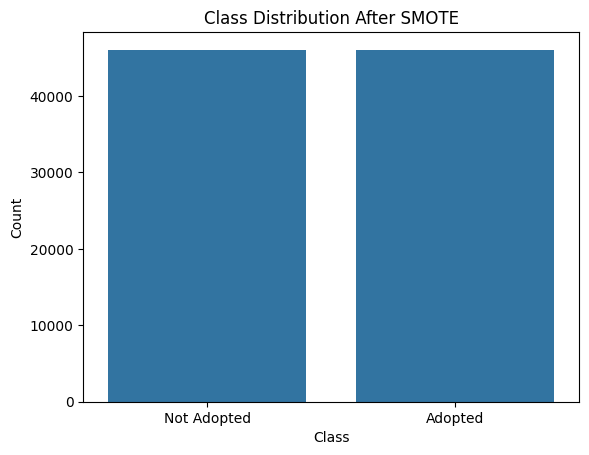

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=y_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=['Not Adopted', 'Adopted'])
plt.show()


# Train-Test split

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Selection & Evaluation

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

model = RandomForestClassifier()

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

cv_results = cross_validate(model, X, y, cv=kfold, scoring=scoring)

print("Cross-Validation Results :")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} Mean: {scores.mean():.4f}  |  Std: {scores.std():.4f}")


Cross-Validation Results :
Accuracy Mean: 0.8853  |  Std: 0.0026
Precision Mean: 0.8480  |  Std: 0.0031
Recall Mean: 0.8869  |  Std: 0.0072
F1 Mean: 0.8670  |  Std: 0.0036


/var/folders/bw/2mkdr3w938z4h0z84x6l4dmr0000gn/T/ipykernel_11028/237172011.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")


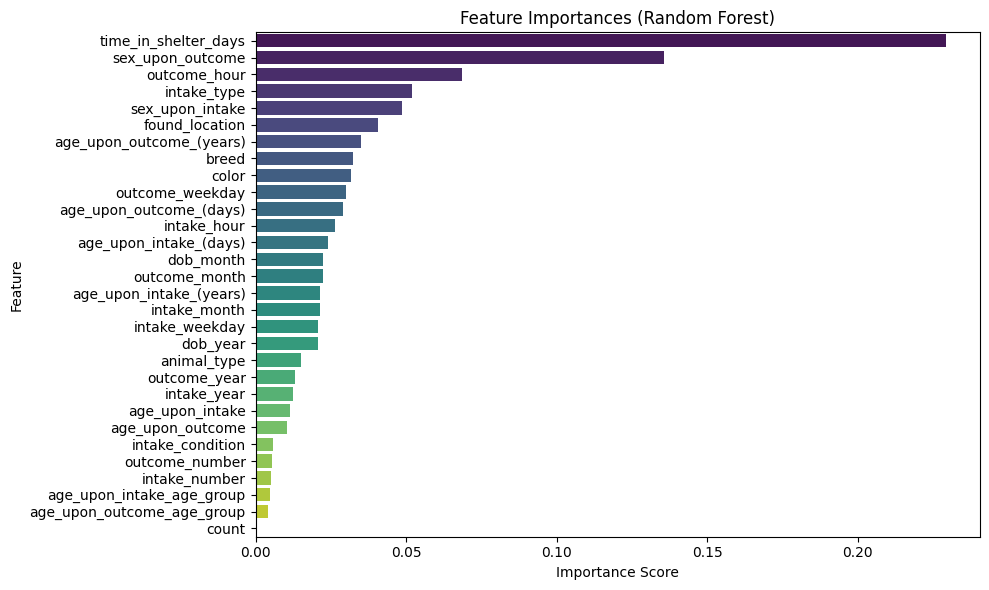

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델 학습 (이미 학습된 모델이면 이 줄 생략)
model = RandomForestClassifier()
model.fit(X, y)

# Feature importance 추출
importances = model.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# Additional code

## Model Comparison

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

#SVM과 Logistic Regression을 위해 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 모델 정의
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "LightGBM": LGBMClassifier(),
    "CatBoost": CatBoostClassifier(verbose=0),  # verbose 끄기
    "SVM": SVC()
}

# 학습 및 예측
for name, model in models.items():
    print(f"\n🔍 {name}")
    
    if name in ["Logistic Regression", "SVM"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        
    print("Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds))



🔍 Logistic Regression
Accuracy: 0.7923178309169648
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      9215
           1       0.80      0.68      0.73      6718

    accuracy                           0.79     15933
   macro avg       0.79      0.78      0.78     15933
weighted avg       0.79      0.79      0.79     15933


🔍 Random Forest


/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: divide by zero encountered in matmul
  grad[:n_features] = X.T @ grad_pointwise + l2_reg_strength * weights
/opt/homebrew/Caskroom/miniforge/base/lib/python3.12/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning: overflow encountered in matmul
  g

Accuracy: 0.8858344316826712
              precision    recall  f1-score   support

           0       0.91      0.89      0.90      9215
           1       0.85      0.88      0.87      6718

    accuracy                           0.89     15933
   macro avg       0.88      0.89      0.88     15933
weighted avg       0.89      0.89      0.89     15933


🔍 LightGBM
[LightGBM] [Info] Number of positive: 26876, number of negative: 36853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1413
[LightGBM] [Info] Number of data points in the train set: 63729, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.421723 -> initscore=-0.315703
[LightGBM] [Info] Start training from score -0.315703
Accuracy: 0.8790560471976401
              precision    recall  f1-score  

## check environment

In [71]:
!python --version


Python 3.12.9


In [73]:
import platform
print(platform.system(), platform.release())

Darwin 24.4.0


In [75]:
import pandas as pd
import sklearn
import matplotlib
import seaborn
import imblearn

print("Python Version:", platform.python_version())
print("pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("seaborn:", seaborn.__version__)
print("imblearn:", imblearn.__version__)


Python Version: 3.12.9
pandas: 2.2.3
scikit-learn: 1.6.1
matplotlib: 3.10.1
seaborn: 0.13.2
imblearn: 0.13.0


In [74]:
!pip freeze


accelerate==1.6.0
accelerator==2024.9.13
addict==2.4.0
appnope @ file:///home/conda/feedstock_root/build_artifacts/appnope_1733332318622/work
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1737352602016/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
boltons @ file:///home/conda/feedstock_root/build_artifacts/boltons_1733827268945/work
bottle==0.12.25
Brotli @ file:///Users/runner/miniforge3/conda-bld/brotli-split_1725267563793/work
cached-property==2.0.1
catboost==1.2.8
certifi @ file:///home/conda/feedstock_root/build_artifacts/certifi_1739515848642/work/certifi
cffi @ file:///Users/runner/miniforge3/conda-bld/cffi_1725560578465/work
charset-normalizer @ file:///home/conda/feedstock_root/build_artifacts/charset-normalizer_1735929714516/work
colorama @ file:///home/conda/feedstock_root/build_artifacts/colorama_1733218098505/work
comm @ file:///home/conda/feedstock_root/build_artifacts/comm_1733502965406/work
conda 